# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [389]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [390]:
#Data for the 20 and 100 SNR levels is stored in 15Dec22
#Data for the 50 and 500 SNR levels is stored in 05Jan23

central_date = "05Feb24"#"09Feb23"

addit_plots = False         # additional plots

ds1_file = "Post_Normalized_SNR_20_06Feb24"
ds2_file = "Post_Normalized_SNR_500_06Feb24"#"Raw_Params_SNR_500_20Jul23"

pN_opt = ds1_file.find('Post_Normalized_')>-1

print(pN_opt)


True


# Define Parameters

In [391]:
with open(f'Intermediate_SimResults//Processed_{central_date}//hprParameter_info_' + central_date + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    SNR_mat = dict['SNR_mat']
    n_noise_realizations = dict['n_noise_realizations']
    num_multistarts = dict['num_multistarts']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    c1_set = dict['c1_set']
    T21_set = dict['T21_set']
    T22_set = dict['T22_set']
    noise_date_oi = dict["noise_date_oi"]
    ob_weight = dict['ob_weight']
    upper_bound = dict['upper_bound']
    handle.close()

n_combos = len(c1_set)*len(T21_set)*len(T22_set)

print(f"There are {n_combos} parameter combos")
agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

There are 225 parameter combos


# Define General Functions

### Small Helper Functions

In [392]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def aggregate(array):
    return np.sum(array*agg_weights**2, axis = -1)

def calc_improvement(old, new):
    return (old - new)/old

# Load Data Sets

In [393]:
### DATA Set 1

with open(f'Intermediate_SimResults//Processed_{central_date}//{ds1_file}.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    data_date_oi = dict['HyperParams']
    ds1_SNR = dict['SNR']
    post_normalized = dict['post_normalized']
    ds1_orcAvg_bias = dict['oracle_bias']
    ds1_orcAvg_var = dict['oracle_var']
    ds1_GCV_bias = dict['GCV_bias']
    ds1_GCV_var = dict['GCV_var']
    ds1_GCV_lambdas = dict['GCV_lambdas']
    ds1_GCV_final_params = dict['GCV_final_params']
    handle.close()

assert(post_normalized == pN_opt)
assert(data_date_oi == central_date)

ds1_orcAvg_MSE = ds1_orcAvg_bias**2 + ds1_orcAvg_var
ds1_nonreg_MSE = ds1_orcAvg_MSE[:,0,:]
ds1_GCV_MSE = ds1_GCV_bias**2 + ds1_GCV_var

In [394]:
### DATA Set 2

with open(f'Intermediate_SimResults//Processed_{central_date}//{ds2_file}.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    data_date_oi = dict['HyperParams']
    ds2_SNR = dict['SNR']
    post_normalized = dict['post_normalized']
    ds2_orcAvg_bias = dict['oracle_bias']
    ds2_orcAvg_var = dict['oracle_var']
    ds2_GCV_bias = dict['GCV_bias']
    ds2_GCV_var = dict['GCV_var']
    ds2_GCV_lambdas = dict['GCV_lambdas']
    ds2_GCV_final_params = dict['GCV_final_params']
    handle.close()

print(post_normalized)
assert(post_normalized == pN_opt)
assert(data_date_oi == central_date)

ds2_orcAvg_MSE = ds2_orcAvg_bias**2 + ds2_orcAvg_var
ds2_nonreg_MSE = ds2_orcAvg_MSE[:,0,:]
ds2_GCV_MSE = ds2_GCV_bias**2 + ds2_GCV_var

True


# Line Plots

In [395]:
### MSE Lines

paramCombos = construct_paramList(c1_set, T21_set, T22_set)

pCombo_ill = [0.4,0.6,50,70]
pC_index_ill = paramCombos.index(pCombo_ill)

ill_GCV_MSE_ds1 = ds1_GCV_MSE[pC_index_ill,:]
ill_oLine_ds1 = ds1_orcAvg_MSE[pC_index_ill,:,:]
ill_oMin_ds1 = np.min(ill_oLine_ds1, axis = 0)
ill_nonReg_ds1 = ds1_nonreg_MSE[pC_index_ill,:]
ill_CRLB_unbiased_ds1 = cov_matrix(*pCombo_ill, ds1_SNR)
ill_ds1_bCRLB_nonreg = [0.014780,   0.068170,   173.292387,     3573.770497] #SNR = 20
ill_ds1_bCRLB_GCV = [0.004659,   0.008510,   148.111938,     474.043215] #SNR = 20


ill_GCV_MSE_ds2 = ds2_GCV_MSE[pC_index_ill,:]
ill_oLine_ds2 = ds2_orcAvg_MSE[pC_index_ill,:,:]
ill_oMin_ds2 = np.min(ill_oLine_ds2, axis = 0)
ill_nonReg_ds2 = ds2_nonreg_MSE[pC_index_ill,:]
ill_CRLB_unbiased_ds2 = cov_matrix(*pCombo_ill, ds2_SNR)
ill_ds2_bCRLB_nonreg = [0.061762,   0.062901,   67.511697,     77.679417] #SNR = 500
ill_ds2_bCRLB_GCV = [0.023000,   0.023536,   29.421658,     101.271021] #SNR = 500

pCombo_well = [0.4,0.6,40,150]
pC_index_well = paramCombos.index(pCombo_well)

well_GCV_MSE_ds1 = ds1_GCV_MSE[pC_index_well,:]
well_oLine_ds1 = ds1_orcAvg_MSE[pC_index_well,:,:]
well_oMin_ds1 = np.min(well_oLine_ds1, axis = 0)
well_nonReg_ds1 = ds1_nonreg_MSE[pC_index_well,:]
well_CRLB_unbiased_ds1 = cov_matrix(*pCombo_well, ds1_SNR)
well_ds1_bCRLB_nonreg = [0.003722,   0.032575,   367.080278,     2515.987766] #SNR = 20
well_ds1_bCRLB_GCV = [0.006912,   0.026668,   257.574586,     1611.689706] #SNR = 20

well_GCV_MSE_ds2 = ds2_GCV_MSE[pC_index_well,:]
well_oLine_ds2 = ds2_orcAvg_MSE[pC_index_well,:,:]
well_oMin_ds2 = np.min(well_oLine_ds2, axis = 0)
well_nonReg_ds2 = ds2_nonreg_MSE[pC_index_well,:]
well_CRLB_unbiased_ds2 = cov_matrix(*pCombo_well, ds2_SNR)
well_ds2_bCRLB_nonreg = [0.000079,   0.000109,   1.309009,     2.541587] #SNR = 500
well_ds2_bCRLB_GCV = [0.000082,   0.000123,   1.269783,     2.902088] #SNR = 500


In [396]:
with open(f'LinePlots_VariousLambdas//varLam_data.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    ill_ds1_lam_array = dict['lam_array']
    ill_ds1_c1_array = dict['c1_array']
    ill_ds1_c2_array = dict['c2_array']
    ill_ds1_T21_array = dict['T21_array']
    ill_ds1_T22_array = dict['T22_array']
    handle.close()

ill_ds1_varLam_array = np.array([ill_ds1_c1_array, ill_ds1_c2_array, ill_ds1_T21_array, ill_ds1_T22_array])

In [397]:
### Variance Lines

ill_GCV_var_ds1 = ds1_GCV_var[pC_index_ill,:]
ill_oLine_var_ds1 = ds1_orcAvg_var[pC_index_ill,:,:]
ill_oMin_var_ds1 = ill_oLine_var_ds1[np.argmin(ill_oLine_ds1, axis = 0),[0,1,2,3]]
ill_nonReg_var_ds1 = ds1_orcAvg_var[pC_index_ill,0,:]

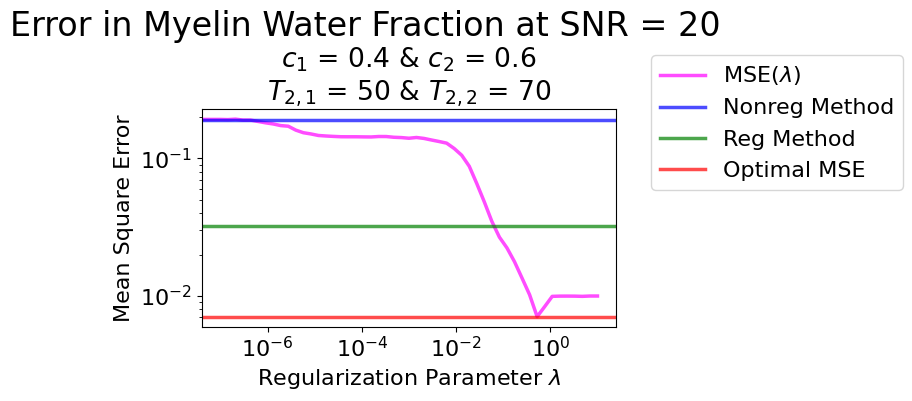

In [398]:
### Simple Image for Line Plots

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"Error in Myelin Water Fraction at SNR = {ds1_SNR}", y=0.90)
plt.rc('font', size = 16)
# fig.suptitle(str(param_name_list) + str(pCombo_oi) + '\nSNR = ' + str(SNR_option) + post_norm_blurb)
ax.loglog(lambdas,  ill_oLine_ds1[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "magenta", linewidth = 2.5)
ax.axhline(y = ill_nonReg_ds1[0], label = r'Nonreg Method', alpha = 0.7, color = "blue", linewidth = 2.5) #NLLS: $\lambda = 0$
ax.axhline(y = ill_GCV_MSE_ds1[0], label = r'Reg Method', alpha = 0.7, color = "green", linewidth = 2.5) #$\lambda = GCV(\lambda)$
ax.axhline(y = ill_oMin_ds1[0], label = r'Optimal MSE', alpha = 0.7, color = "red", linewidth = 2.5)
# ax.axhline(y = ill_CRLB_unbiased_ds1[0,0], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5)
# ax.axhline(y = ill_ds1_bCRLB_nonreg[0], label = r'Nonreg Biased CRLB', alpha = 0.7, color = "cyan", linewidth = 2.5)
# ax.axhline(y = ill_ds1_bCRLB_GCV[0], label = r'Reg Biased CRLB', alpha = 0.7, color = "blue", linewidth = 2.5)
ax.set_xlabel(r'Regularization Parameter $\lambda$')
ax.set_ylabel('Mean Square Error')
ax.set_title(r'$c_1$' + f' = {pCombo_ill[0]} & ' + r'$c_2$' + f' = {pCombo_ill[1]}\n' + 
                r'$T_{2,1}$' + f' = {pCombo_ill[2]} & ' + r'$T_{2,2}$' + f' = {pCombo_ill[3]}')
handles, labels = ax.get_legend_handles_labels()


fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.65))
plt.show()

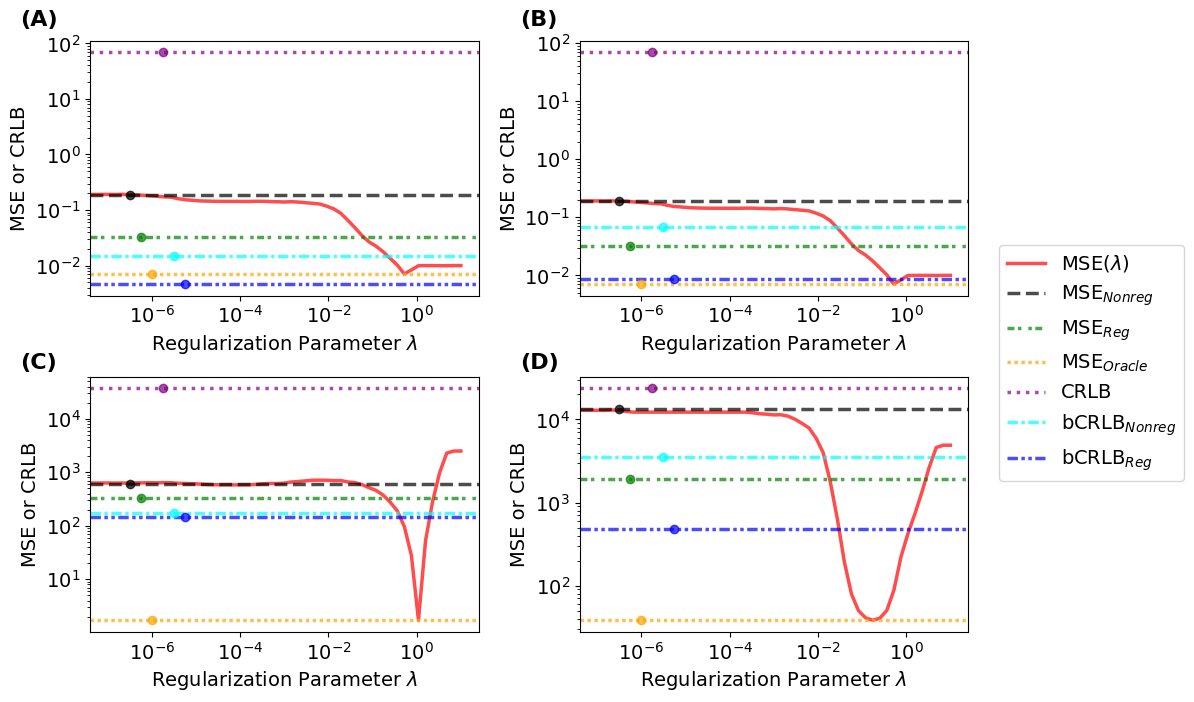

In [399]:
log_stand = np.logspace(-6.5, -5.25, 6)

plt.rc('font', size = 14)
fig, ax = plt.subplots(2,2, figsize=(10,7), tight_layout=True)
# fig.suptitle(f"{param_name_list} :: {pCombo_ill}\nSNR = {ds1_SNR}")
for i in range(4):
    ax[i//2, i%2].loglog(lambdas, ill_oLine_ds1[:,i], label = r'MSE($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
    # ax[i//2, i%2].loglog(lambdas, ill_ds1_varLam_array[i,:], label = r'CRLB MSE($\lambda$)', alpha = 0.7, color = "brown", linewidth = 2.5)
    ax[i//2, i%2].axhline(y = ill_nonReg_ds1[i], label = r'MSE$_{Nonreg}$', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$   
    ax[i//2, i%2].axhline(y = ill_GCV_MSE_ds1[i], label = r'MSE$_{Reg}$', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
    ax[i//2, i%2].axhline(y = ill_oMin_ds1[i], label = r'MSE$_{Oracle}$', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
    ax[i//2, i%2].axhline(y = ill_CRLB_unbiased_ds1[i,i], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
    ax[i//2, i%2].axhline(y = ill_ds1_bCRLB_nonreg[i], label = r'bCRLB$_{Nonreg}$', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
    ax[i//2, i%2].axhline(y = ill_ds1_bCRLB_GCV[i], label = r'bCRLB$_{Reg}$', alpha = 0.7, color = "blue", linewidth = 2.5, ls = (0, (3, 1, 1, 1, 1, 1)))
    ax[i//2, i%2].set_xlabel(r'Regularization Parameter $\lambda$')
    ax[i//2, i%2].set_ylabel('MSE or CRLB')
    # ax[i//2, i%2].set_title(param_name_list[i])
    ax[i//2, i%2].loglog(log_stand[0], ill_nonReg_ds1[i], alpha = 0.7, color = "black", ls = "", marker = 'o')
    ax[i//2, i%2].loglog(log_stand[1], ill_GCV_MSE_ds1[i], alpha = 0.7, color = "green", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[2], ill_oMin_ds1[i], alpha = 0.7, color = "orange", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[3], ill_CRLB_unbiased_ds1[i,i], alpha = 0.7, color = "purple", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[4], ill_ds1_bCRLB_nonreg[i], alpha = 0.7, color = "cyan", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[5], ill_ds1_bCRLB_GCV[i], alpha = 0.7, color = "blue", ls = '', marker = 'o')
    
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))

plt.rc('font', size = 16)
fig.text(0.05,0.99, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.55,0.99, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.5, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.55,0.5, '(D)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

plt.show()

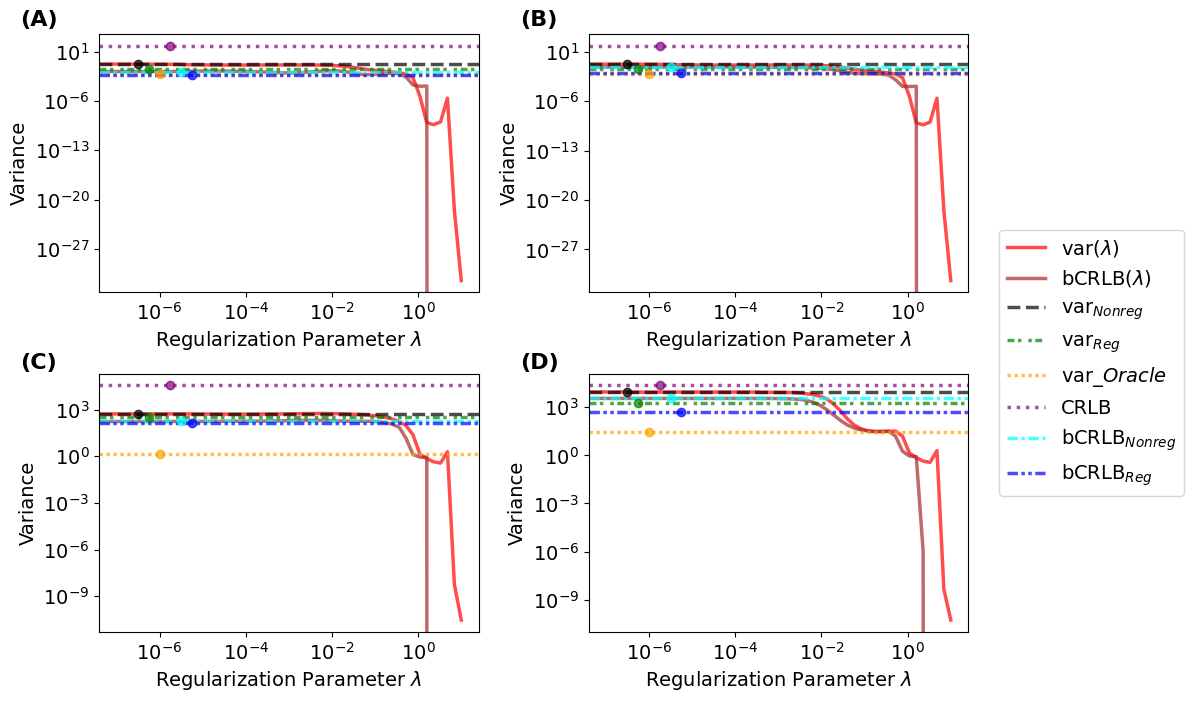

In [400]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(2,2, figsize=(10,7), tight_layout=True)
# fig.suptitle(f"{param_name_list} :: {pCombo_ill}\nSNR = {ds1_SNR}")
for i in range(4):
    ax[i//2, i%2].loglog(lambdas, ill_oLine_var_ds1[:,i], label = r'var($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
    ax[i//2, i%2].loglog(lambdas, ill_ds1_varLam_array[i,:], label = r'bCRLB($\lambda$)', alpha = 0.7, color = "brown", linewidth = 2.5)
    ax[i//2, i%2].axhline(y = ill_nonReg_var_ds1[i], label = r'var$_{Nonreg}$', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$   
    ax[i//2, i%2].axhline(y = ill_GCV_var_ds1[i], label = r'var$_{Reg}$', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
    ax[i//2, i%2].axhline(y = ill_oMin_var_ds1[i], label = r'var_${Oracle}$', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
    ax[i//2, i%2].axhline(y = ill_CRLB_unbiased_ds1[i,i], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
    ax[i//2, i%2].axhline(y = ill_ds1_bCRLB_nonreg[i], label = r'bCRLB$_{Nonreg}$', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
    ax[i//2, i%2].axhline(y = ill_ds1_bCRLB_GCV[i], label = r'bCRLB$_{Reg}$', alpha = 0.7, color = "blue", linewidth = 2.5, ls = (0, (3, 1, 1, 1, 1, 1)))
    ax[i//2, i%2].set_xlabel(r'Regularization Parameter $\lambda$')
    ax[i//2, i%2].set_ylabel('Variance')
    # ax[i//2, i%2].set_title(param_name_list[i])
    ax[i//2, i%2].loglog(log_stand[0], ill_nonReg_var_ds1[i], alpha = 0.7, color = "black", ls = "", marker = 'o')
    ax[i//2, i%2].loglog(log_stand[1], ill_GCV_var_ds1[i], alpha = 0.7, color = "green", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[2], ill_oMin_var_ds1[i], alpha = 0.7, color = "orange", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[3], ill_CRLB_unbiased_ds1[i,i], alpha = 0.7, color = "purple", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[4], ill_ds1_bCRLB_nonreg[i], alpha = 0.7, color = "cyan", ls = '', marker = 'o')
    ax[i//2, i%2].loglog(log_stand[5], ill_ds1_bCRLB_GCV[i], alpha = 0.7, color = "blue", ls = '', marker = 'o')
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))

plt.rc('font', size = 16)
fig.text(0.05,0.99, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.55,0.99, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.5, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.55,0.5, '(D)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

plt.show()

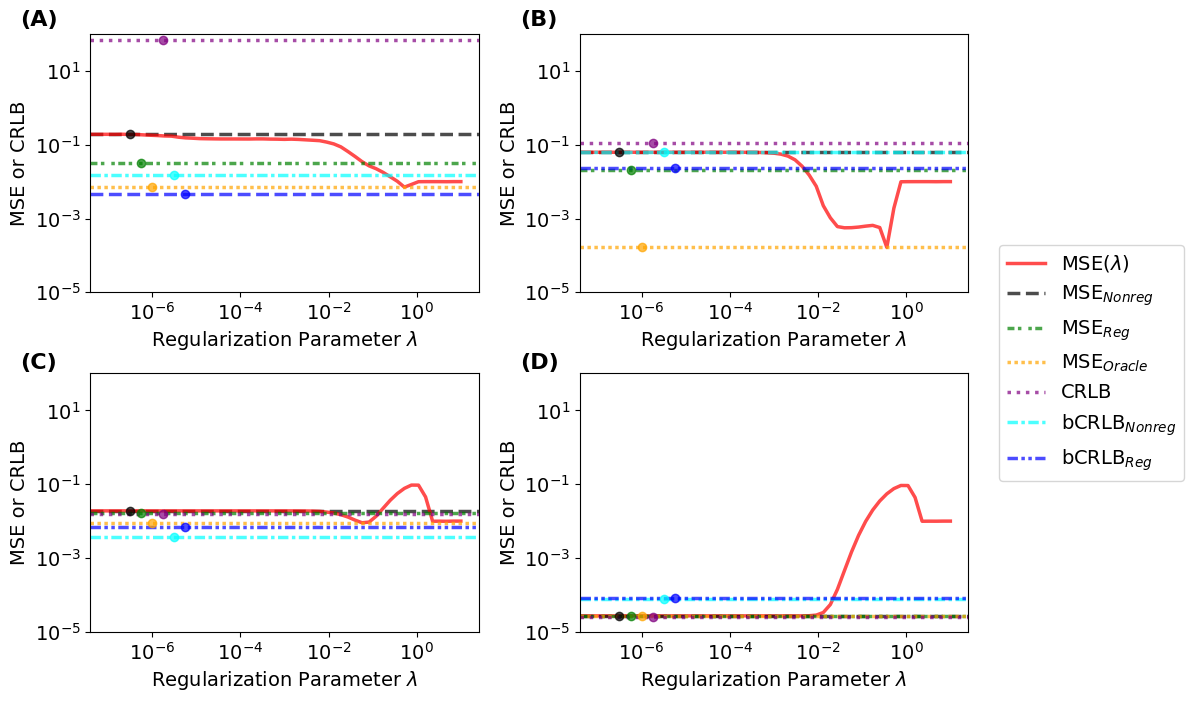

In [401]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(2,2, figsize=(10,7), tight_layout=True)
# fig.suptitle(f"{param_name_list[0]} Estimates")

########### ds1 
ax[0,0].axhline(y = ill_nonReg_ds1[0], label = r'NLLS', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$
ax[0,0].loglog(lambdas, ill_oLine_ds1[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
ax[0,0].axhline(y = ill_oMin_ds1[0], label = r'Oracle', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
ax[0,0].axhline(y = ill_GCV_MSE_ds1[0], label = r'GCV', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
ax[0,0].axhline(y = ill_CRLB_unbiased_ds1[0,0], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
ax[0,0].axhline(y = ill_ds1_bCRLB_nonreg[0], label = r'Nonreg bCRLB', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
ax[0,0].axhline(y = ill_ds1_bCRLB_GCV[0], label = r'GCV bCRLB', alpha = 0.7, color = "blue", linewidth = 2.5, ls = "--")
ax[0,0].loglog(log_stand[0], ill_nonReg_ds1[0], alpha = 0.7, color = "black", ls = "", marker = 'o')
ax[0,0].loglog(log_stand[1], ill_GCV_MSE_ds1[0], alpha = 0.7, color = "green", ls = '', marker = 'o')
ax[0,0].loglog(log_stand[2], ill_oMin_ds1[0], alpha = 0.7, color = "orange", ls = '', marker = 'o')
ax[0,0].loglog(log_stand[3], ill_CRLB_unbiased_ds1[0,0], alpha = 0.7, color = "purple", ls = '', marker = 'o')
ax[0,0].loglog(log_stand[4], ill_ds1_bCRLB_nonreg[0], alpha = 0.7, color = "cyan", ls = '', marker = 'o')
ax[0,0].loglog(log_stand[5], ill_ds1_bCRLB_GCV[0], alpha = 0.7, color = "blue", ls = '', marker = 'o')
ax[0,0].set_ylim([10**-5,10**2])
ax[0,0].set_xlabel(r'Regularization Parameter $\lambda$')
ax[0,0].set_ylabel('MSE or CRLB')
# ax[0,0].set_title(f"{pCombo_ill} at SNR = {ds1_SNR}")

ax[0,1].axhline(y = ill_nonReg_ds2[0], label = r'NLLS', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$
ax[0,1].loglog(lambdas, ill_oLine_ds2[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
ax[0,1].axhline(y = ill_oMin_ds2[0], label = r'Oracle', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
ax[0,1].axhline(y = ill_GCV_MSE_ds2[0], label = r'GCV', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
ax[0,1].axhline(y = ill_CRLB_unbiased_ds2[0,0], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
ax[0,1].axhline(y = ill_ds2_bCRLB_nonreg[0], label = r'Nonreg bCRLB', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
ax[0,1].axhline(y = ill_ds2_bCRLB_GCV[0], label = r'GCV bCRLB', alpha = 0.7, color = "blue", linewidth = 2.5, ls = (0, (3, 1, 1, 1, 1, 1)))
ax[0,1].loglog(log_stand[0], ill_nonReg_ds2[0], alpha = 0.7, color = "black", ls = "", marker = 'o')
ax[0,1].loglog(log_stand[1], ill_GCV_MSE_ds2[0], alpha = 0.7, color = "green", ls = '', marker = 'o')
ax[0,1].loglog(log_stand[2], ill_oMin_ds2[0], alpha = 0.7, color = "orange", ls = '', marker = 'o')
ax[0,1].loglog(log_stand[3], ill_CRLB_unbiased_ds2[0,0], alpha = 0.7, color = "purple", ls = '', marker = 'o')
ax[0,1].loglog(log_stand[4], ill_ds2_bCRLB_nonreg[0], alpha = 0.7, color = "cyan", ls = '', marker = 'o')
ax[0,1].loglog(log_stand[5], ill_ds2_bCRLB_GCV[0], alpha = 0.7, color = "blue", ls = '', marker = 'o')
ax[0,1].set_ylim([10**-5,10**2])
ax[0,1].set_xlabel(r'Regularization Parameter $\lambda$')
ax[0,1].set_ylabel('MSE or CRLB')
# ax[0,1].set_title(f"{pCombo_ill} at SNR = {ds2_SNR}")

ax[1,0].axhline(y = well_nonReg_ds1[0], label = r'NLLS', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$
ax[1,0].loglog(lambdas, well_oLine_ds1[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
ax[1,0].axhline(y = well_oMin_ds1[0], label = r'Oracle', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
ax[1,0].axhline(y = well_GCV_MSE_ds1[0], label = r'GCV', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
ax[1,0].axhline(y = well_CRLB_unbiased_ds1[0,0], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
ax[1,0].axhline(y = well_ds1_bCRLB_nonreg[0], label = r'Nonreg bCRLB', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
ax[1,0].axhline(y = well_ds1_bCRLB_GCV[0], label = r'GCV bCRLB', alpha = 0.7, color = "blue", linewidth = 2.5, ls = (0, (3, 1, 1, 1, 1, 1)))
ax[1,0].loglog(log_stand[0], well_nonReg_ds1[0], alpha = 0.7, color = "black", ls = "", marker = 'o')
ax[1,0].loglog(log_stand[1], well_GCV_MSE_ds1[0], alpha = 0.7, color = "green", ls = '', marker = 'o')
ax[1,0].loglog(log_stand[2], well_oMin_ds1[0], alpha = 0.7, color = "orange", ls = '', marker = 'o')
ax[1,0].loglog(log_stand[3], well_CRLB_unbiased_ds1[0,0], alpha = 0.7, color = "purple", ls = '', marker = 'o')
ax[1,0].loglog(log_stand[4], well_ds1_bCRLB_nonreg[0], alpha = 0.7, color = "cyan", ls = '', marker = 'o')
ax[1,0].loglog(log_stand[5], well_ds1_bCRLB_GCV[0], alpha = 0.7, color = "blue", ls = '', marker = 'o')
ax[1,0].set_ylim([10**-5,10**2])
ax[1,0].set_xlabel(r'Regularization Parameter $\lambda$')
ax[1,0].set_ylabel('MSE or CRLB')
# ax[1,0].set_title(f"{pCombo_well} at SNR = {ds1_SNR}")

ax[1,1].loglog(lambdas, well_oLine_ds2[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
ax[1,1].axhline(y = well_nonReg_ds2[0], label = r'MSE$_{Nonreg}$', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$
ax[1,1].axhline(y = well_GCV_MSE_ds2[0], label = r'MSE$_{Reg}$', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
ax[1,1].axhline(y = well_oMin_ds2[0], label = r'MSE$_{Oracle}$', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
ax[1,1].axhline(y = well_CRLB_unbiased_ds2[0,0], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
ax[1,1].axhline(y = well_ds2_bCRLB_nonreg[0], label = r'bCRLB$_{Nonreg}$', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
ax[1,1].axhline(y = well_ds2_bCRLB_GCV[0], label = r'bCRLB$_{Reg}$', alpha = 0.7, color = "blue", linewidth = 2.5, ls = (0, (3, 1, 1, 1, 1, 1)))
ax[1,1].loglog(log_stand[0], well_nonReg_ds2[0], alpha = 0.7, color = "black", ls = "", marker = 'o')
ax[1,1].loglog(log_stand[1], well_GCV_MSE_ds2[0], alpha = 0.7, color = "green", ls = '', marker = 'o')
ax[1,1].loglog(log_stand[2], well_oMin_ds2[0], alpha = 0.7, color = "orange", ls = '', marker = 'o')
ax[1,1].loglog(log_stand[3], well_CRLB_unbiased_ds2[0,0], alpha = 0.7, color = "purple", ls = '', marker = 'o')
ax[1,1].loglog(log_stand[4], well_ds2_bCRLB_nonreg[0], alpha = 0.7, color = "cyan", ls = '', marker = 'o')
ax[1,1].loglog(log_stand[5], well_ds2_bCRLB_GCV[0], alpha = 0.7, color = "blue", ls = '', marker = 'o')
ax[1,1].set_ylim([10**-5,10**2])
ax[1,1].set_xlabel(r'Regularization Parameter $\lambda$')
ax[1,1].set_ylabel('MSE or CRLB')
# ax[1,1].set_title(f"{pCombo_well} at SNR = {ds2_SNR}")

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))

plt.rc('font', size = 16)
fig.text(0.05,0.99, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.55,0.99, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.5, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.55,0.5, '(D)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

plt.show()

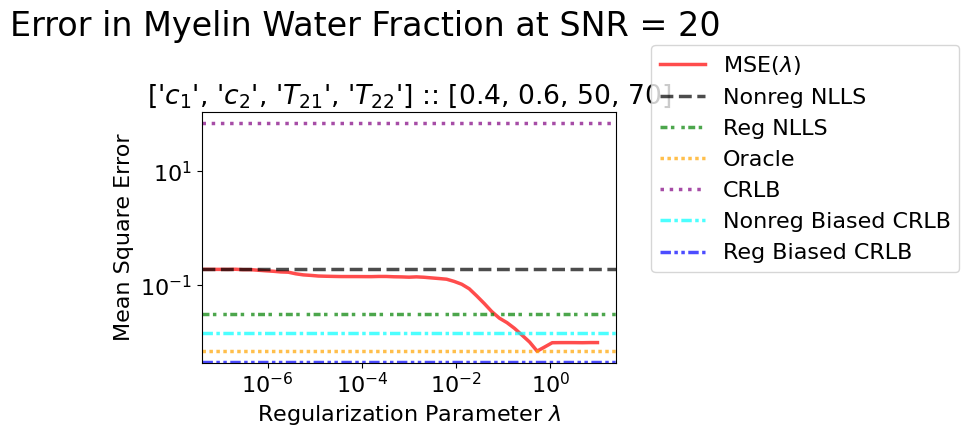

In [402]:
### Official Image for Line Plots

# pCombo_oi = [0.4,0.6,50,70]
# pC_index = paramCombos.index(pCombo_oi)

# single_pC_GCV_MSE = GCV_MSE[pC_index,:]
# single_pC_orcAvg = orcAvg_MSE[pC_index,:,:]
# single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
# single_pC_orcErr = minErr_agg_MSE[pC_index,:]
# single_pC_nonReg = nonreg_MSE[pC_index,:]

# CRLB_unbiased = cov_matrix(pCombo_oi[0], pCombo_oi[1], pCombo_oi[2], pCombo_oi[3], SNR_option)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"Error in Myelin Water Fraction at SNR = {ds1_SNR}")
plt.rc('font', size = 16)
# fig.suptitle(str(param_name_list) + str(pCombo_oi) + '\nSNR = ' + str(SNR_option) + post_norm_blurb)
ax.loglog(lambdas, ill_oLine_ds1[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "red", linewidth = 2.5)
ax.axhline(y = ill_nonReg_ds1[0], label = r'Nonreg NLLS', alpha = 0.7, color = "black", linewidth = 2.5, ls = "--") #NLLS: $\lambda = 0$   
ax.axhline(y = ill_GCV_MSE_ds1[0], label = r'Reg NLLS', alpha = 0.7, color = "green", linewidth = 2.5, ls = (0, (2, 1, 1))) #$\lambda = GCV(\lambda)$
ax.axhline(y = ill_oMin_ds1[0], label = r'Oracle', alpha = 0.7, color = "orange", linewidth = 2.5, ls = (0, (1, 1)))
ax.axhline(y = ill_CRLB_unbiased_ds1[0,0], label = r'CRLB', alpha = 0.7, color = "purple", linewidth = 2.5, ls = ":")
ax.axhline(y = ill_ds1_bCRLB_nonreg[0], label = r'Nonreg Biased CRLB', alpha = 0.7, color = "cyan", linewidth = 2.5, ls = (0, (3, 1, 1, 1)))
ax.axhline(y = ill_ds1_bCRLB_GCV[0], label = r'Reg Biased CRLB', alpha = 0.7, color = "blue", linewidth = 2.5, ls = (0, (3, 1, 1, 1, 1, 1)))
ax.set_xlabel(r'Regularization Parameter $\lambda$')
ax.set_ylabel('Mean Square Error')
ax.set_title("Parameter " + param_name_list[0] + ' Estimate MSE')
ax.set_xlabel(r'Regularization Parameter $\lambda$')
ax.set_ylabel('Mean Square Error')
ax.set_title(f"{param_name_list} :: {pCombo_ill}")
handles, labels = ax.get_legend_handles_labels()


# pCombo_oi = [0.4,0.6,30,110]
# pC_index = paramCombos.index(pCombo_oi)

# single_pC_GCV_MSE = GCV_MSE[pC_index,:]
# single_pC_orcAvg = orcAvg_MSE[pC_index,:,:]
# single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
# single_pC_orcErr = minErr_agg_MSE[pC_index,:]
# single_pC_nonReg = nonreg_MSE[pC_index,:]

# CRLB_unbiased = cov_matrix(pCombo_oi[0], pCombo_oi[1], pCombo_oi[2], pCombo_oi[3], SNR_option)

# ax[1].loglog(lambdas, single_pC_orcAvg[:,0], label = r'MSE($\lambda$)', alpha = 0.7, color = "magenta")
# ax[1].axhline(y = single_pC_nonReg[0], label = r'NR', alpha = 0.7, color = "blue") #NLLS: $\lambda = 0$
# ax[1].axhline(y = single_pC_GCV_MSE[0], label = r'GCV', alpha = 0.7, color = "green") #$\lambda = GCV(\lambda)$
# # ax[i//2, i%2].axhline(y = single_pC_orcAvg_min[i], label = r'$\lambda$ = Oracle 1', alpha = 0.7, color = "red")
# # ax[i//2, i%2].axhline(y = single_pC_orcErr[i], label = r'$\lambda$ = Oracle 2', alpha = 0.7, color = "orange")
# ax[1].axhline(y = CRLB_unbiased[0,0], label = r'CRLB', alpha = 0.7, color = "black")
# ax[1].set_xlabel(r'Regularization Parameter $\lambda$')
# ax[1].set_ylabel('Mean Square Error')
# ax[1].set_title(r'$c_1$' + f' = {pCombo_oi[0]} & ' + r'$c_2$' + f' = {pCombo_oi[1]}\n' + 
#                 r'$T_{2,1}$' + f' = {pCombo_oi[2]} & ' + r'$T_{2,2}$' + f' = {pCombo_oi[3]}')


fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.65))
plt.show()

#c1 outliers = 17 
#c2 outliers = 17 
#T21 outliers = 0 
#T22 outliers = 19


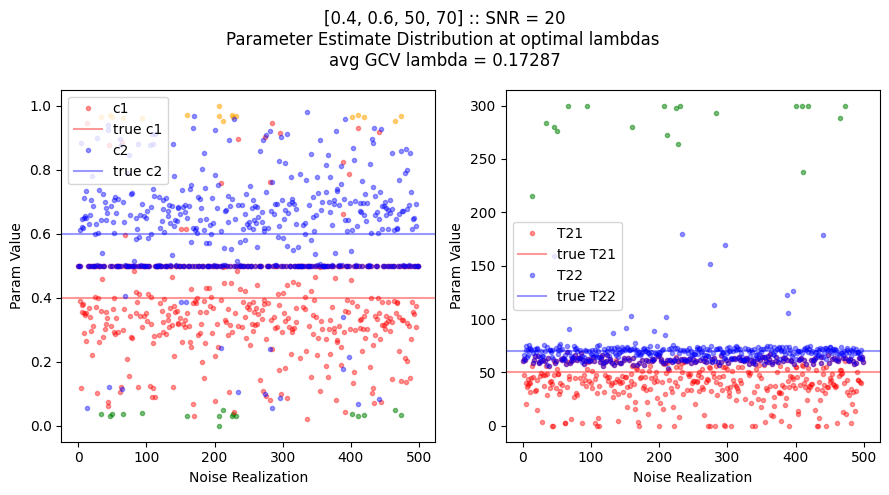

In [403]:
lambda_val_oi = np.mean(ds1_GCV_lambdas, axis = 1)[pC_index_ill]

param_means = np.mean(ds1_GCV_final_params[pC_index_ill, :], axis = 0)
param_std = np.std(ds1_GCV_final_params[pC_index_ill, :], axis = 0)
param_topBar = param_means + 3*param_std
param_lowBar = param_means - 3*param_std

c1_outlier_index = np.array(np.where(np.logical_or(ds1_GCV_final_params[pC_index_ill,:,0]<param_lowBar[0], ds1_GCV_final_params[pC_index_ill,:,0]>param_topBar[0])))
c2_outlier_index = np.array(np.where(np.logical_or(ds1_GCV_final_params[pC_index_ill,:,1]<param_lowBar[1], ds1_GCV_final_params[pC_index_ill,:,1]>param_topBar[1])))
T21_outlier_index = np.array(np.where(np.logical_or(ds1_GCV_final_params[pC_index_ill,:,2]<param_lowBar[2], ds1_GCV_final_params[pC_index_ill,:,2]>param_topBar[2])))
T22_outlier_index = np.array(np.where(np.logical_or(ds1_GCV_final_params[pC_index_ill,:,3]<param_lowBar[3], ds1_GCV_final_params[pC_index_ill,:,3]>param_topBar[3])))

print(f"#c1 outliers = {np.size(c1_outlier_index)} \n#c2 outliers = {np.size(c2_outlier_index)} \n#T21 outliers = {np.size(T21_outlier_index)} \n#T22 outliers = {np.size(T22_outlier_index)}")

c1_normal_index = np.setdiff1d(np.arange(0,500), c1_outlier_index)
c2_normal_index = np.setdiff1d(np.arange(0,500), c2_outlier_index)
T21_normal_index = np.setdiff1d(np.arange(0,500), T21_outlier_index)
T22_normal_index = np.setdiff1d(np.arange(0,500), T22_outlier_index)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(str(pCombo_ill) + ' :: SNR = ' + str(ds1_SNR) + f"\nParameter Estimate Distribution at optimal lambdas \navg GCV lambda = {np.round(lambda_val_oi,5)}")
ax[0].plot(c1_outlier_index, ds1_GCV_final_params[pC_index_ill,c1_outlier_index,0], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(c2_outlier_index, ds1_GCV_final_params[pC_index_ill,c2_outlier_index,1], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(c1_normal_index, ds1_GCV_final_params[pC_index_ill,c1_normal_index,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_ill[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(c2_normal_index, ds1_GCV_final_params[pC_index_ill,c2_normal_index,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_ill[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_outlier_index, ds1_GCV_final_params[pC_index_ill,T21_outlier_index,2], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T22_outlier_index, ds1_GCV_final_params[pC_index_ill,T22_outlier_index,3], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_normal_index, ds1_GCV_final_params[pC_index_ill,T21_normal_index,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_ill[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(T22_normal_index, ds1_GCV_final_params[pC_index_ill,T22_normal_index,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_ill[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

# Show Improvements

In [404]:
ds1_nonreg_bias = ds1_orcAvg_bias[:,0,:]
ds1_nonreg_var = ds1_orcAvg_var[:,0,:]

GCV_imp_MSE = calc_improvement(ds1_nonreg_MSE, ds1_GCV_MSE)
GCV_imp_bias_sq = calc_improvement(ds1_nonreg_bias**2, ds1_GCV_bias**2)
GCV_imp_var = calc_improvement(ds1_nonreg_var, ds1_GCV_var)

nonreg_agg_MSE = np.sum(ds1_nonreg_MSE*agg_weights**2, axis = -1)
GCV_agg_MSE = np.sum(ds1_GCV_MSE*agg_weights**2, axis = -1)
nonreg_agg_var = np.sum(ds1_nonreg_var*agg_weights**2, axis = -1)
GCV_agg_var = np.sum(ds1_GCV_var*agg_weights**2, axis = -1)
nonreg_agg_squareBi = np.sum(ds1_nonreg_bias**2*agg_weights**2, axis = -1)
GCV_agg_squareBi = np.sum(ds1_GCV_bias**2*agg_weights**2, axis = -1)

GCV_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, GCV_agg_MSE)
GCV_agg_imp_squareBi = calc_improvement(nonreg_agg_squareBi, GCV_agg_squareBi)
GCV_agg_imp_var = calc_improvement(nonreg_agg_var, GCV_agg_var)


In [405]:
#Choose the parameter of interest

POI = 0

##### GCV

In [406]:
size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

GCV_imp_MSE = np.reshape(GCV_imp_MSE,size_array)
GCV_imp_bias_sq = np.reshape(GCV_imp_bias_sq,size_array)
GCV_imp_var = np.reshape(GCV_imp_var,size_array)

Post Normalization = True


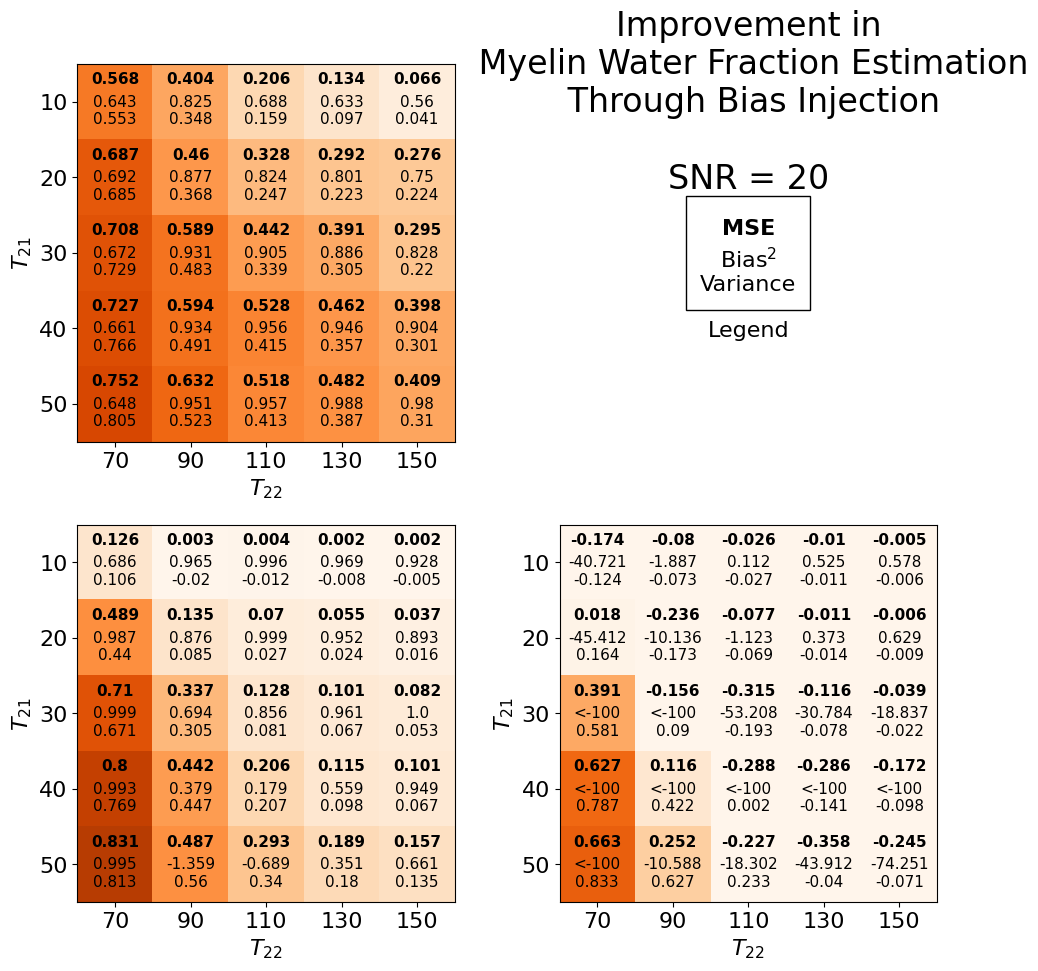

In [407]:
### Official Figure for Improvement


#Parameter of interest, using the standard indexing for this code
print(f"Post Normalization = {pN_opt}")

def gen_patchwork_panel(ind_x, ind_y, c1_COI, var_temp, sq_bias_temp, MSE_temp):
    ######## bottom left
    plt.rc('font', size = 16)
    # ax[ind_x, ind_y].set_title(r'$c_1$' + f" = {np.round(c1_set[c1_COI],2)} & " + r'$c_2$' + f" = {np.round(1 - c1_set[c1_COI],2)}")
    imc1 = ax[ind_x, ind_y].imshow(MSE_temp[c1_COI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax[ind_x, ind_y].set_xticks(np.arange(len(T22_set)))
    ax[ind_x, ind_y].set_yticks(np.arange(len(T21_set)))
    ax[ind_x, ind_y].set_xticklabels(T22_set)
    ax[ind_x, ind_y].set_yticklabels(T21_set)
    ax[ind_x, ind_y].set_ylabel(r'$T_{21}$')
    ax[ind_x, ind_y].set_xlabel(r'$T_{22}$')

    plt.rc('font', size = 11)
    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            MSE_summary = (f"{round(MSE_temp[c1_COI,i,j,POI], 3)}")
            if sq_bias_temp[c1_COI,i,j,POI] < -100 :
                sq_bias_string = "<-100"
            else:
                sq_bias_string = f"{round(sq_bias_temp[c1_COI,i,j,POI], 3)}"
            comp_summary = (f"\n{sq_bias_string}\n{round(var_temp[c1_COI,i,j,POI], 3)}")
            text = ax[ind_x, ind_y].text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
            text2 = ax[ind_x, ind_y].text(j, i, comp_summary, ha="center", va="center", color="black")

    return

c1_combos_oi = [2,3,5]
x_patches = [0,1,1]
y_patches = [0,0,1]


plt.rc('font', size = 16)
fig, ax = plt.subplots(2,2, figsize = (10, 10), tight_layout=True)

for ii in range(3):
    gen_patchwork_panel(x_patches[ii], y_patches[ii], c1_combos_oi[ii], GCV_imp_var, GCV_imp_bias_sq, GCV_imp_MSE)

plt.rc('font', size = 20)
ax[0,1].axis('off')
ax[0,1].set_title(f"Improvement in\n Myelin Water Fraction Estimation\n Through Bias Injection\n\nSNR = {ds1_SNR}", y = 0.8, pad = -35)

plt.rc('font', size = 16)
rect = mpl.patches.Rectangle((0.35,0.35), 0.3, 0.3, linewidth = 1, edgecolor = 'k', facecolor = 'none')
ax[0,1].add_patch(rect)
text = ax[0,1].text(0.5, 0.55, 'MSE', color="black", weight = "bold", ha = 'center')
text2 = ax[0,1].text(0.5, 0.40, r'Bias$^2$' + '\nVariance', color="black", ha = 'center')
text3 = ax[0,1].text(0.5, 0.28, 'Legend', color="black", ha = 'center')
        

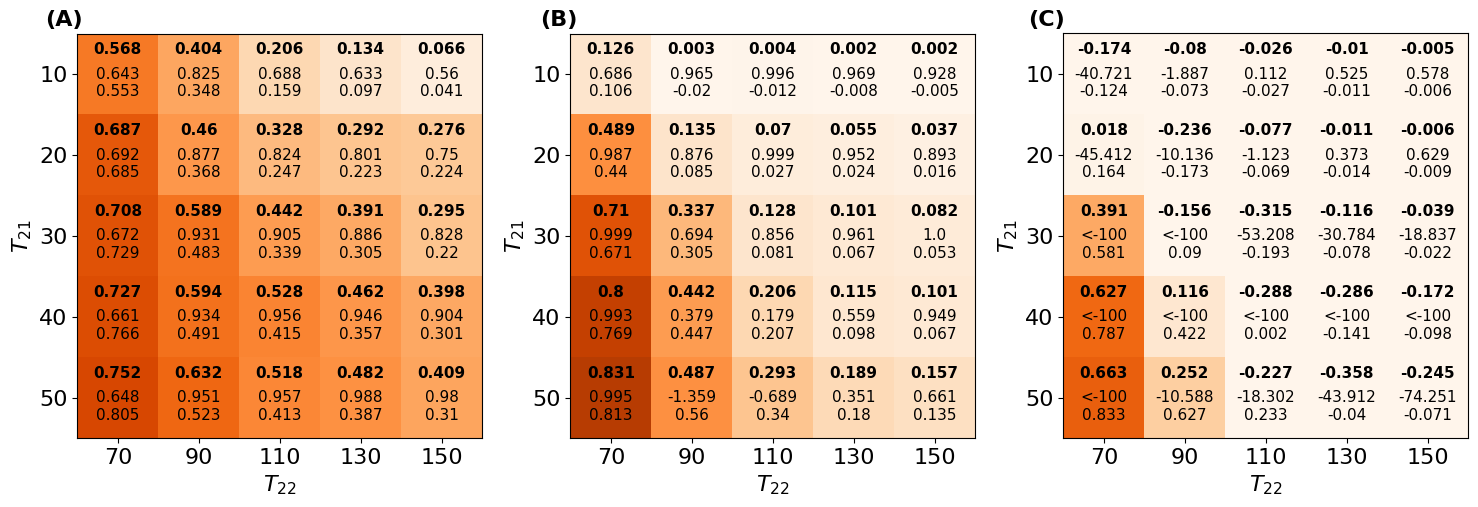

In [408]:
def gen_patchwork_panel_single(ind_x, c1_COI, var_temp, sq_bias_temp, MSE_temp):
    ######## bottom left
    plt.rc('font', size = 16)
    # ax[ind_x].set_title(r'$c_1$' + f" = {np.round(c1_set[c1_COI],2)} & " + r'$c_2$' + f" = {np.round(1 - c1_set[c1_COI],2)}")
    imc1 = ax[ind_x].imshow(MSE_temp[c1_COI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax[ind_x].set_xticks(np.arange(len(T22_set)))
    ax[ind_x].set_yticks(np.arange(len(T21_set)))
    ax[ind_x].set_xticklabels(T22_set)
    ax[ind_x].set_yticklabels(T21_set)
    ax[ind_x].set_ylabel(r'$T_{21}$')
    ax[ind_x].set_xlabel(r'$T_{22}$')

    plt.rc('font', size = 11)
    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            MSE_summary = (f"{round(MSE_temp[c1_COI,i,j,POI], 3)}")
            if sq_bias_temp[c1_COI,i,j,POI] < -100 :
                sq_bias_string = "<-100"
            else:
                sq_bias_string = f"{round(sq_bias_temp[c1_COI,i,j,POI], 3)}"
            comp_summary = (f"\n{sq_bias_string}\n{round(var_temp[c1_COI,i,j,POI], 3)}")
            text = ax[ind_x].text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
            text2 = ax[ind_x].text(j, i, comp_summary, ha="center", va="center", color="black")

    return


c1_combos_oi = [2,3,5]
x_patches = [0,1,2]

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,3, figsize = (15, 6), tight_layout=True)

for ii in range(len(c1_combos_oi)):
    gen_patchwork_panel_single(x_patches[ii], c1_combos_oi[ii], GCV_imp_var, GCV_imp_bias_sq, GCV_imp_MSE)

# plt.rc('font', size = 20)
# ax[0,1].axis('off')
# plt.suptitle(f"SNR = {ds1_SNR}")

plt.rc('font', size = 16)
fig.text(0.05,0.86, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.86, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.86, '(C)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

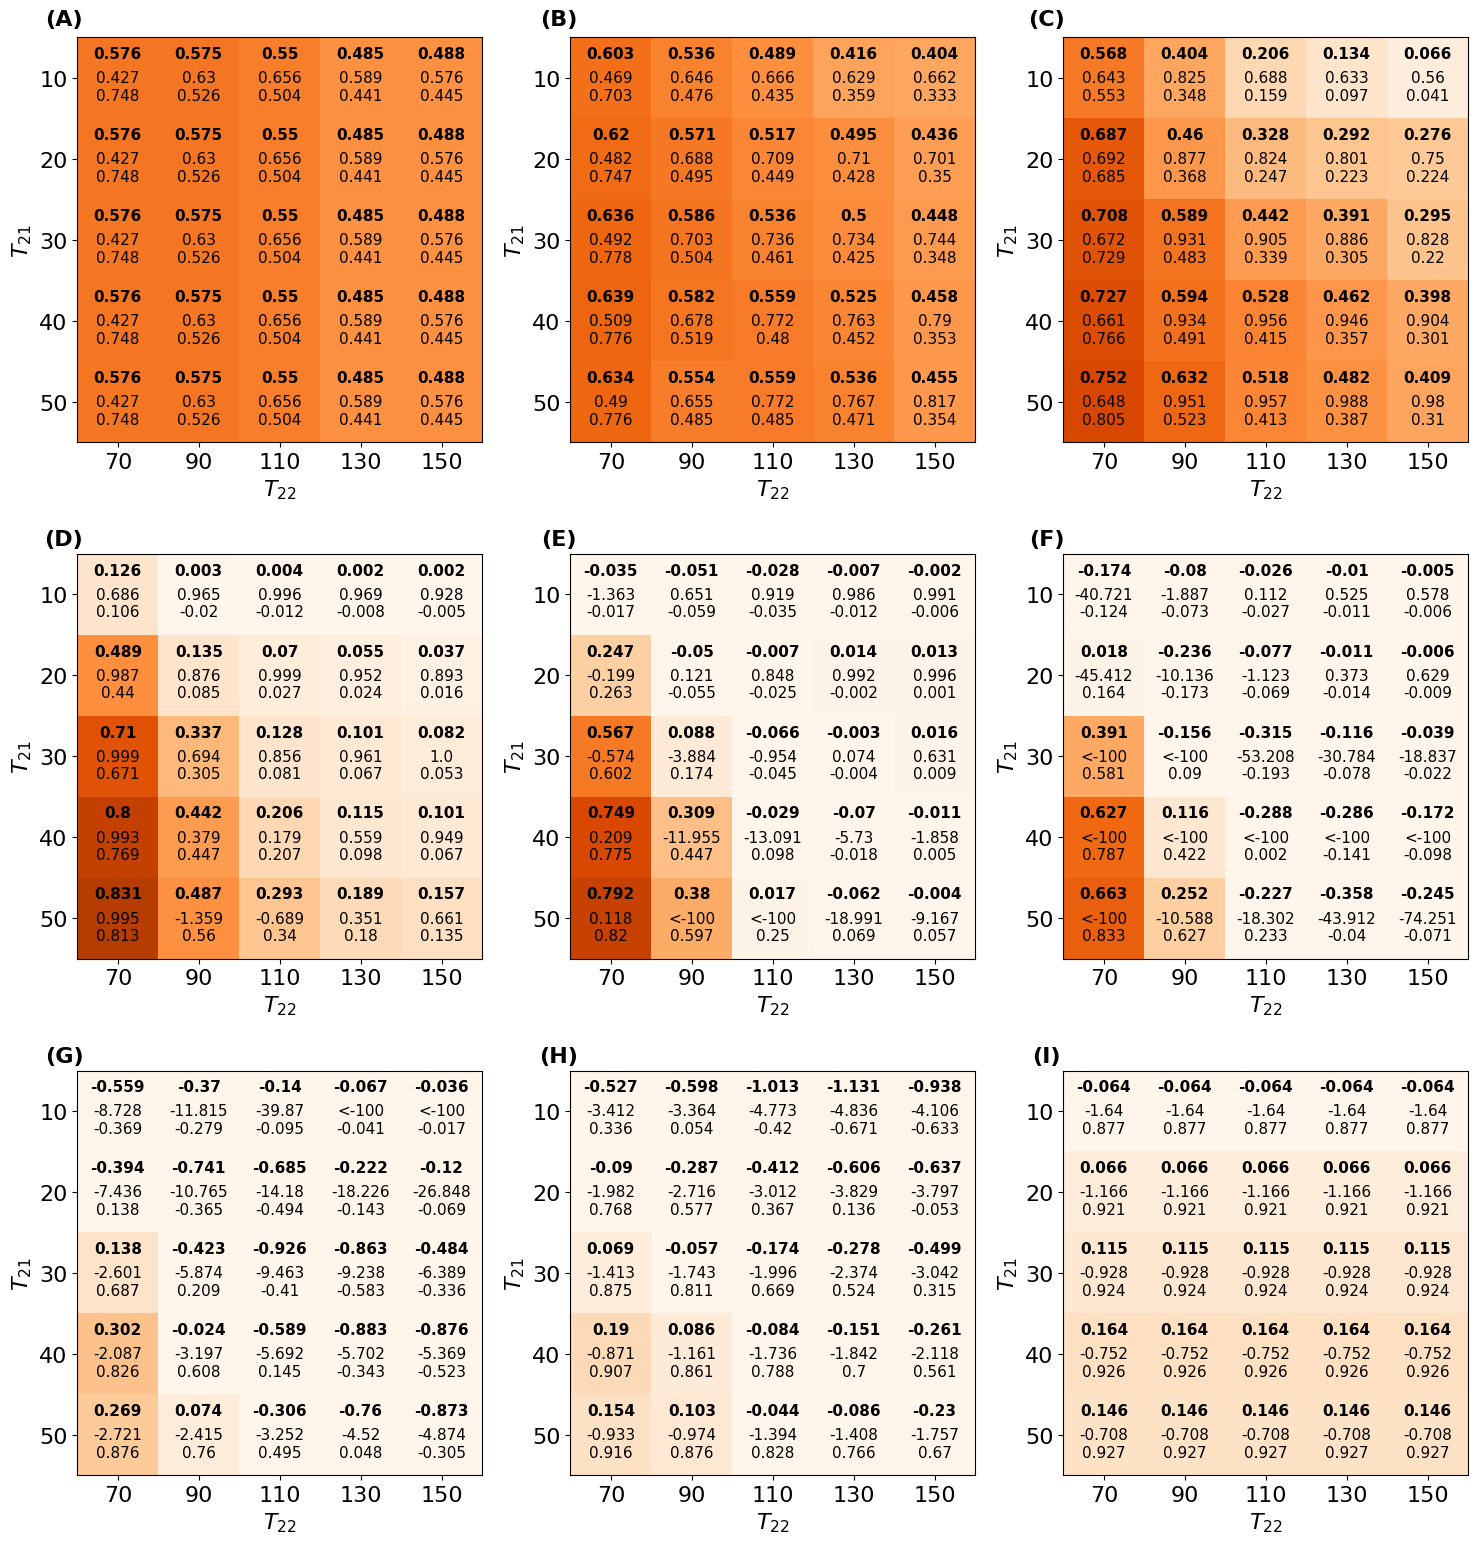

In [409]:
c1_combos_oi = np.arange(0,9,1)
x_patches = [0,0,0,1,1,1,2,2,2]
y_patches = [0,1,2,0,1,2,0,1,2]


plt.rc('font', size = 16)
fig, ax = plt.subplots(3,3, figsize = (15, 16), tight_layout=True)

for ii in range(len(c1_combos_oi)):
    gen_patchwork_panel(x_patches[ii], y_patches[ii], c1_combos_oi[ii], GCV_imp_var, GCV_imp_bias_sq, GCV_imp_MSE)

plt.rc('font', size = 20)
# ax[0,1].axis('off')
# plt.suptitle(f"SNR = {ds1_SNR}")

# plt.rc('font', size = 16)

# lab = ["MSE","Bias Sq", "Var"]
# r = mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',visible=False)

# fig.legend([r,r,r],lab, loc='center left', bbox_to_anchor=(0.5, 1), handlelength=0, handletextpad=0, fancybox=True)
# plt.rc('text', usetex=True)
# MSE_text = r'$\textbf{MSE}$'
# BSQ_text = r'Bias$^2$'

# TITLE = ax[0,1].text(1,-1.5, f'{MSE_text}\n{BSQ_text}\nVar',fontsize = 14,zorder = 6, color = 'k',
#                 bbox={'facecolor':'silver', 'alpha':0.5, 'pad':8})
# plt.rc('text', usetex=False)

plt.rc('font', size = 16)
fig.text(0.05,0.97, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.97, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.97, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.645, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.645, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.645, '(F)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.322, '(G)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.322, '(H)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.322, '(I)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)
        